<a href="https://colab.research.google.com/github/YouJoohyung/myfirst-project/blob/master/4_2_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pypi.org/project/keras-unet/0.1.2/#description  
https://keras.io/examples/vision/oxford_pets_image_segmentation/ 

# U-Net : Semantic Segmentation   

## Model Structure 확인하기

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.backend import int_shape
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Conv2DTranspose,
    MaxPooling2D, Dropout, Input, concatenate, Cropping2D,
    SpatialDropout2D ) 
tf.__version__,keras.__version__

('2.8.2', '2.8.0')

In [ ]:
def conv2d_block(inputs, filters=16, padding='valid'):
    c = Conv2D(filters, kernel_size=(3,3), activation='relu', 
              kernel_initializer="he_normal", padding=padding)(inputs)
    c = Conv2D(filters, kernel_size=(3,3), activation='relu', 
              kernel_initializer="he_normal", padding=padding)(c)
    return c

In [ ]:
def unet(input_shape, num_classes=1, filters=64, num_layers=4,
         padding='valid', output_activation='sigmoid'):
    x = inputs = Input(input_shape)
    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(x, filters=filters, padding=padding)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), strides=2) (x)
        filters = filters*2 # double the number of filters with each layer
    x = Dropout(0.5)(x)
    x = conv2d_block(x, filters=filters, padding=padding)
    for conv in reversed(down_layers):
        filters //= 2 # decreasing number of filters with each layer 
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='valid') (x)
        ch, cw = get_crop_shape(int_shape(conv), int_shape(x))
        conv = Cropping2D(cropping=(ch, cw))(conv)
        x = concatenate([x, conv])
        x = conv2d_block(x, filters=filters, padding=padding)
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation) (x)    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [ ]:
model = unet(input_shape=(572,572,1),padding='valid')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 572, 572, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 570, 570, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 568, 568, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

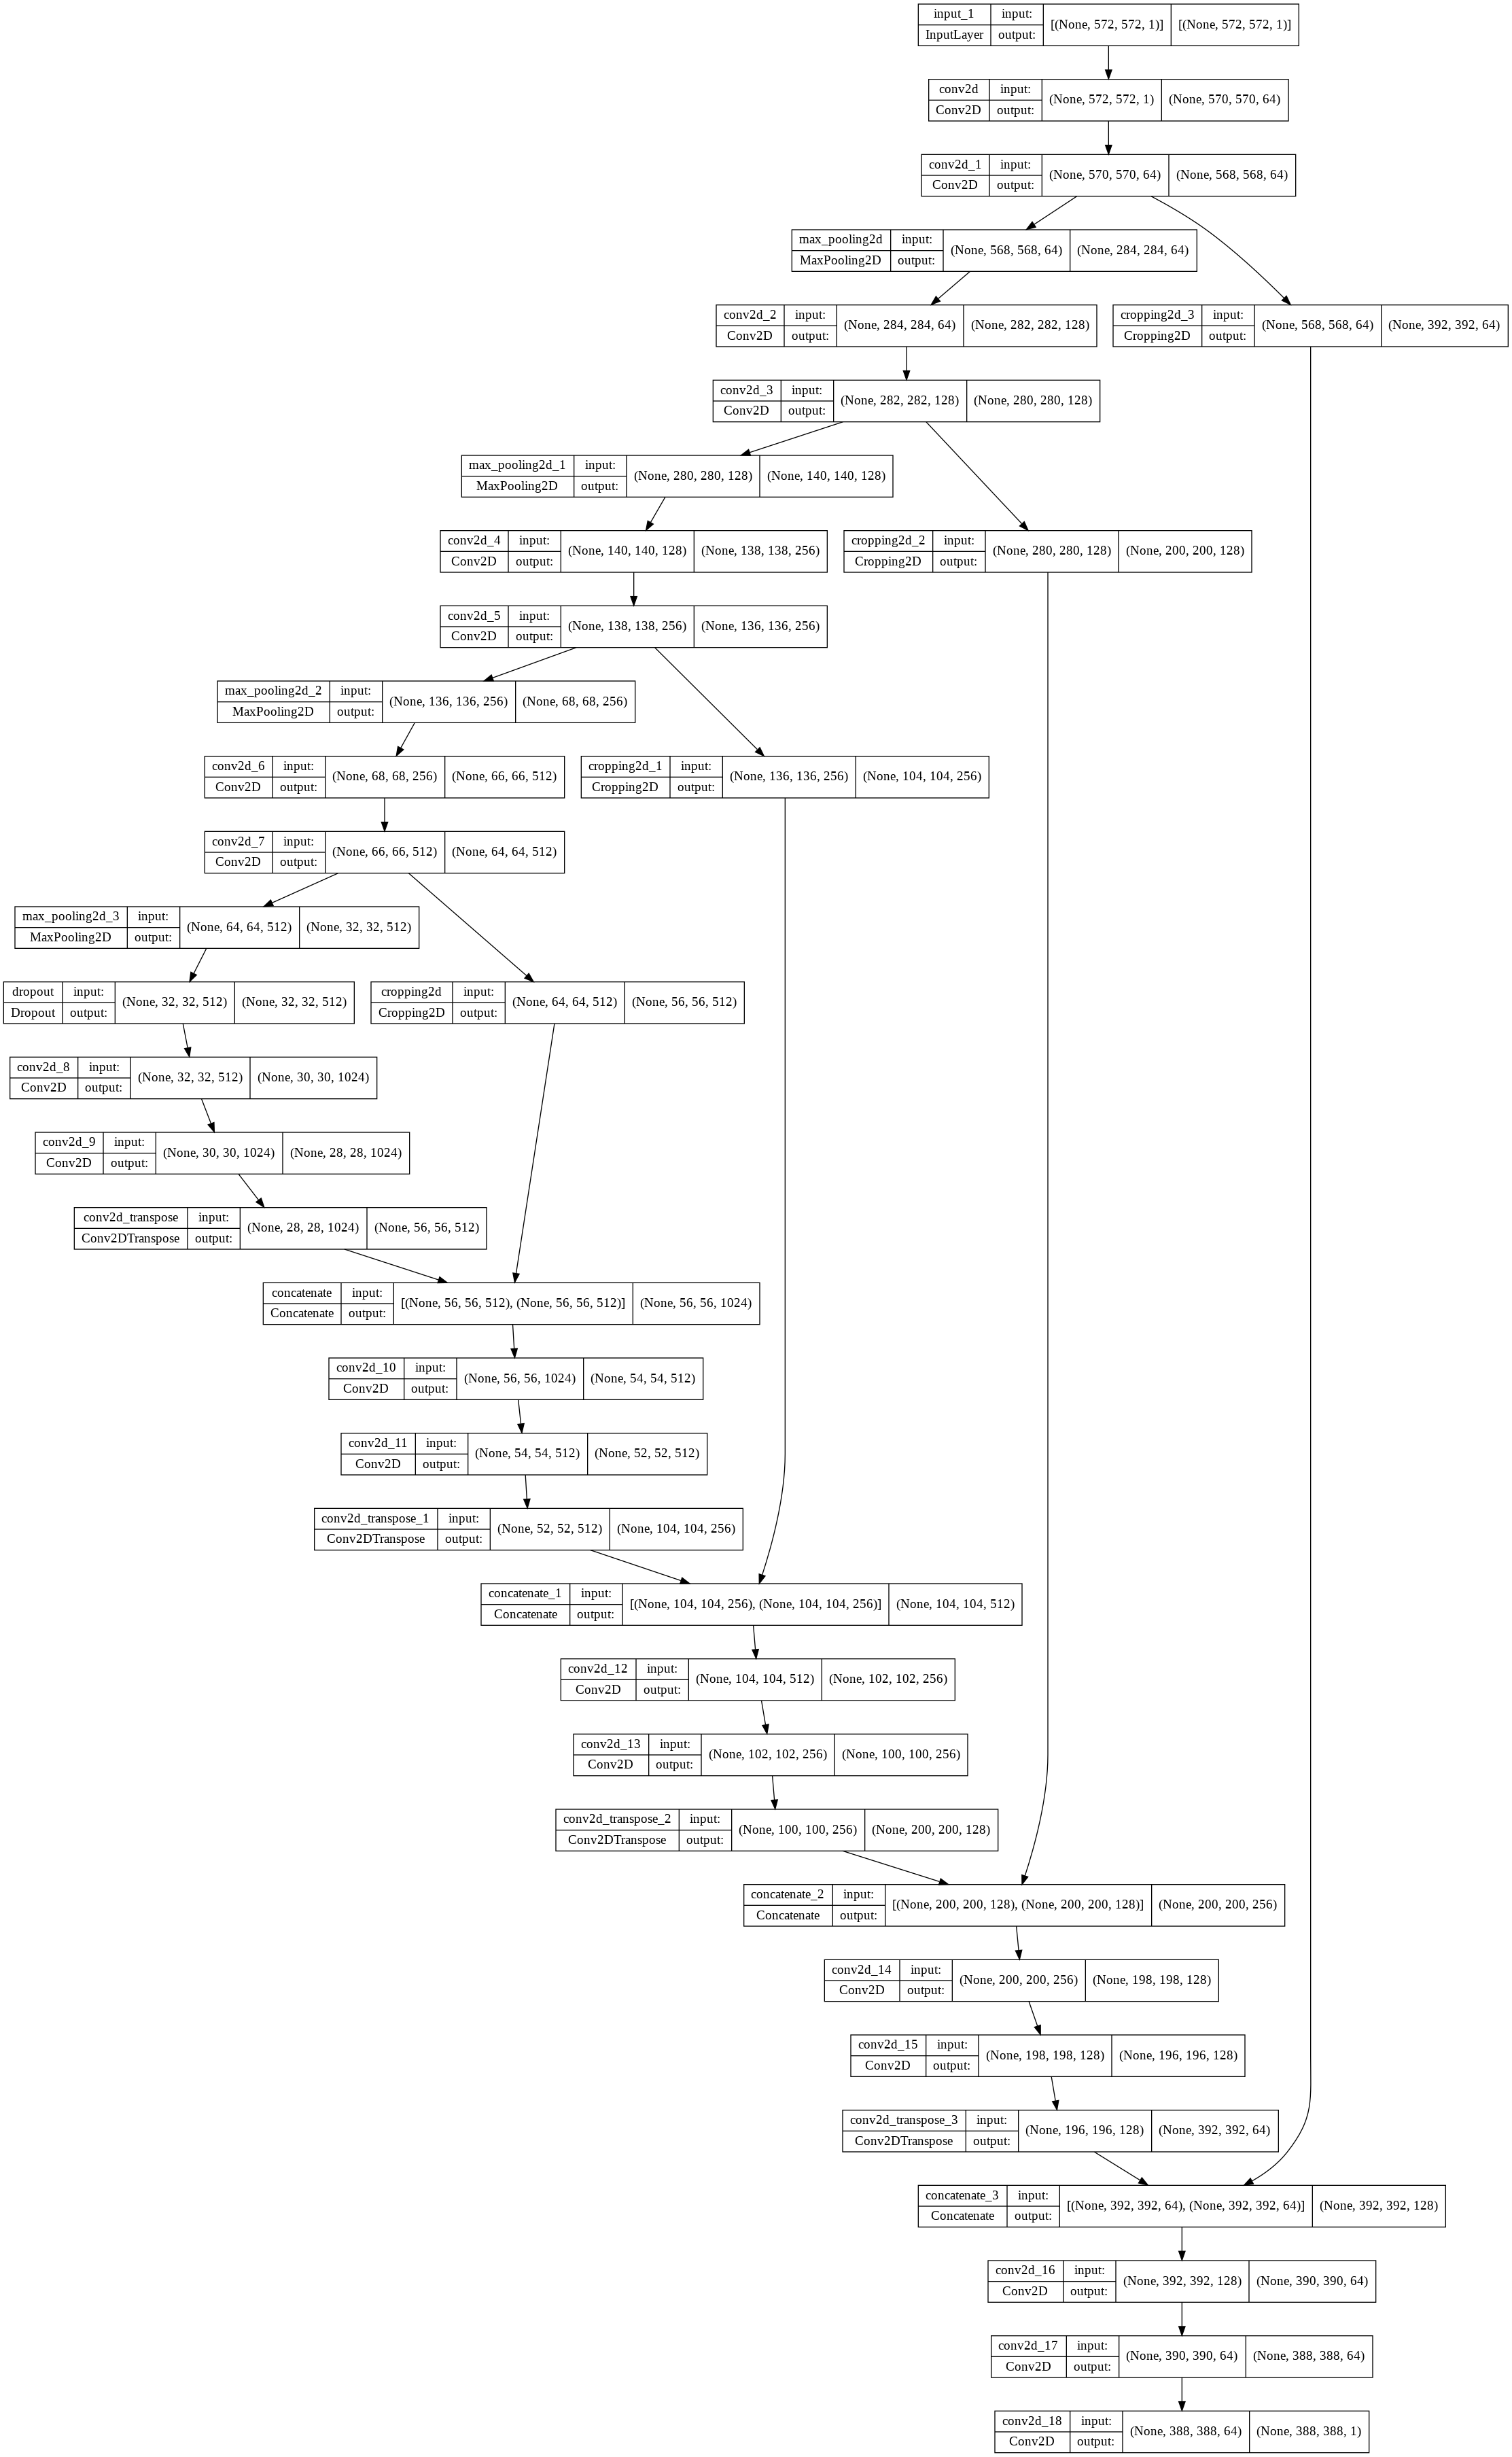

In [ ]:
tf.keras.utils.plot_model(model,'unet-model0.png',show_shapes=True)

# UNet 실습 
 

## Download the data
**oxford-iiit.zip file을 code folder에서 unzip해서 사용하세요**

In [ ]:
## 시간이 오래걸리거나 중지될 수 있음 ( 800MB ) 
!curl -L https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -o images.tar.gz
!curl -L https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -o annotations.tar.gz

# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz 

# !tar -zxcvf images.tar.gz
# !tar -zxcvf annotations.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   350    0     0    602      0 --:--:-- --:--:-- --:--:--   601
100  755M  100  755M    0     0  33.6M      0  0:00:22  0:00:22 --:--:-- 36.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   355    0     0   1050      0 --:--:-- --:--:-- --:--:--  1050
100 18.2M  100 18.2M    0     0  10.2M      0  0:00:01  0:00:01 --:--:-- 22.6M


## Image와 Segmentation maske들 path를 mapping 

In [ ]:
import os
 
input_dir = "./images/"
target_dir = "./annotations/trimaps/" 
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
./images/Abyssinian_1.jpg | ./annotations/trimaps/Abyssinian_1.png
./images/Abyssinian_10.jpg | ./annotations/trimaps/Abyssinian_10.png
./images/Abyssinian_100.jpg | ./annotations/trimaps/Abyssinian_100.png
./images/Abyssinian_101.jpg | ./annotations/trimaps/Abyssinian_101.png
./images/Abyssinian_102.jpg | ./annotations/trimaps/Abyssinian_102.png
./images/Abyssinian_103.jpg | ./annotations/trimaps/Abyssinian_103.png
./images/Abyssinian_104.jpg | ./annotations/trimaps/Abyssinian_104.png
./images/Abyssinian_105.jpg | ./annotations/trimaps/Abyssinian_105.png
./images/Abyssinian_106.jpg | ./annotations/trimaps/Abyssinian_106.png
./images/Abyssinian_107.jpg | ./annotations/trimaps/Abyssinian_107.png


## Image와 Segmentaion mask 확인하기 

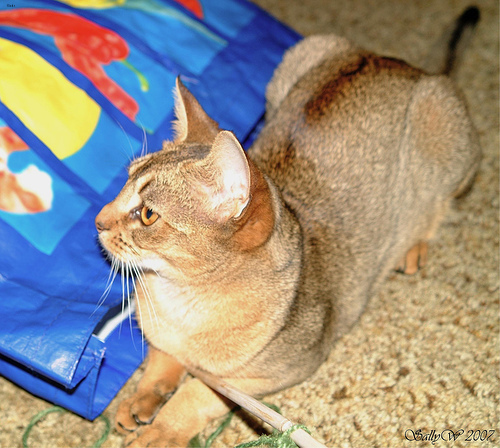

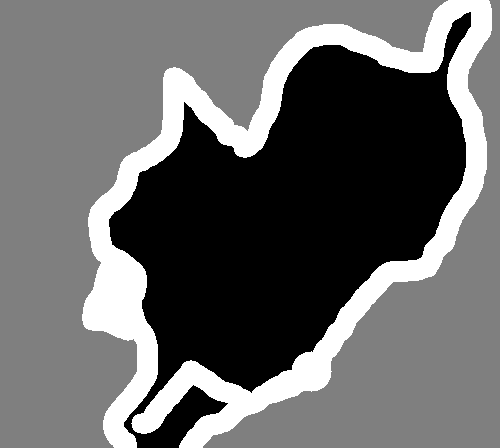

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Sequence class를 사용하여 batch단위로 data loading 준비 
**keras.utils.Sequence class는 ImageDataGenerator base class**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

## 7390개 data중 1000개를 validation data로 분리


In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 실습용 model define 
**Resolution, depth 변경**

In [ ]:
model = unet(input_shape=(160,160,3),num_classes=3, num_layers=3, padding='same',output_activation='softmax')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 160, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 160, 160, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

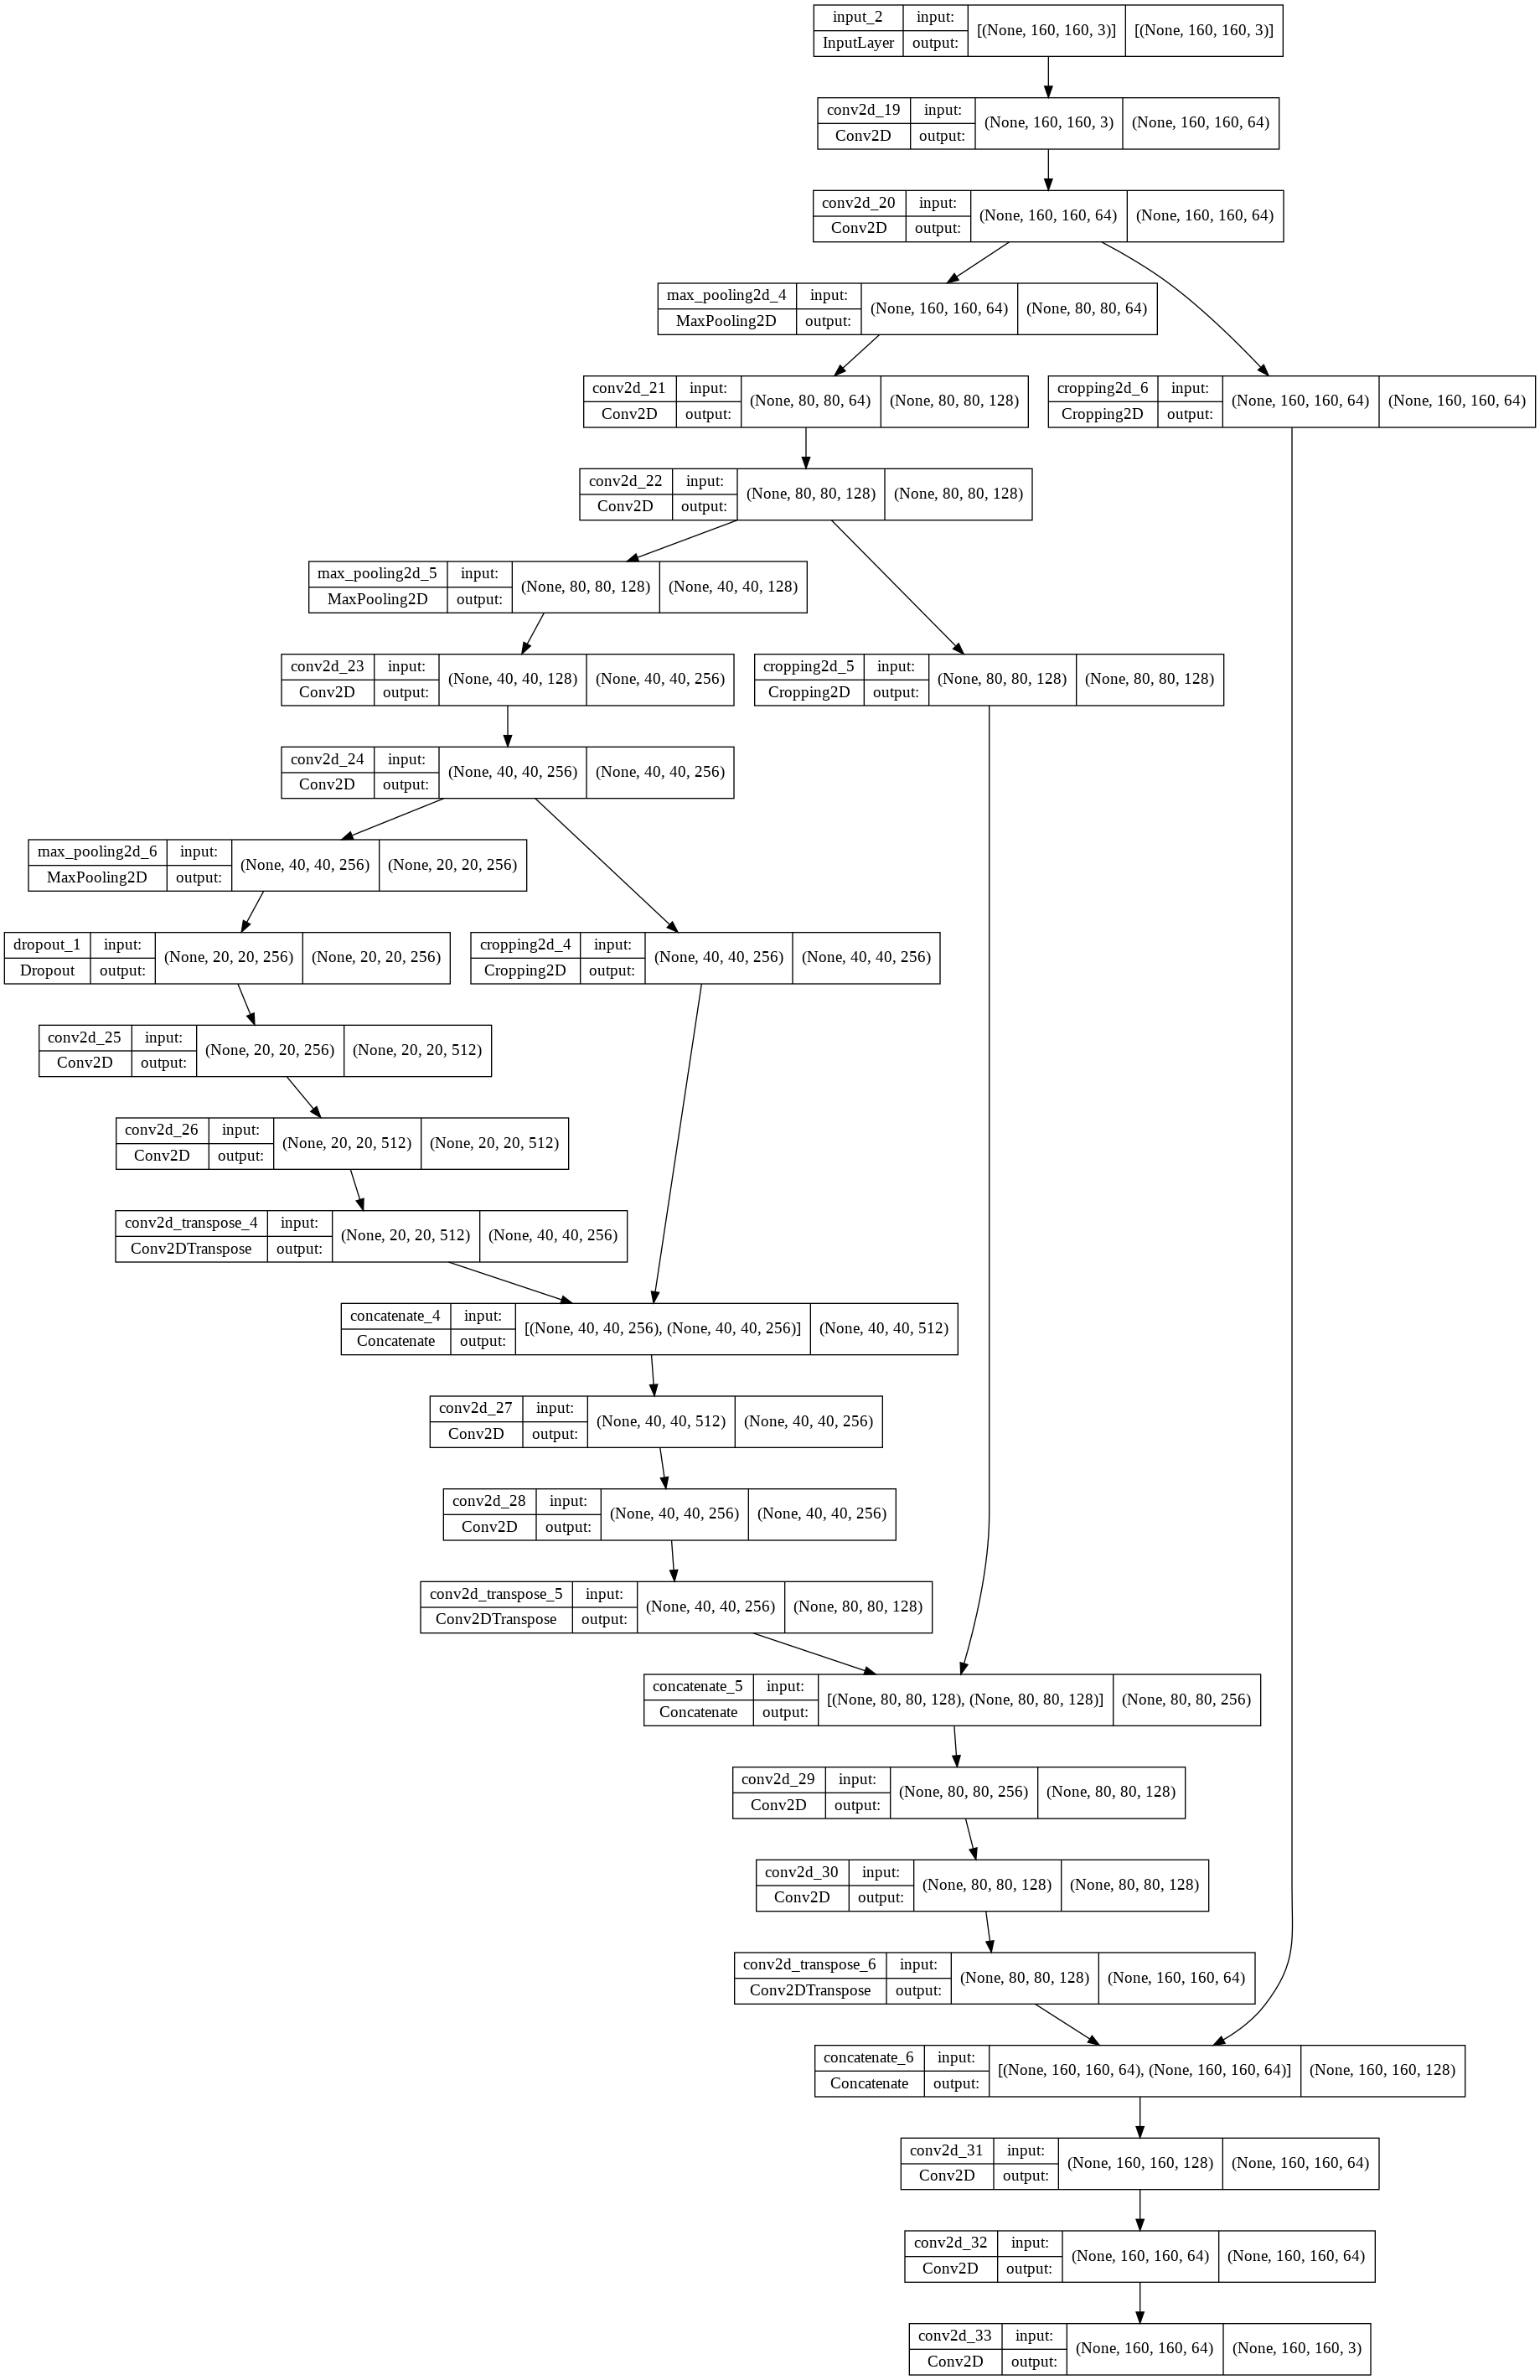

In [ ]:
tf.keras.utils.plot_model(model,'unet-model1.png',show_shapes=True)

## Train the model


Epoch 15/15  
199/199 [==============================] - 88s 441ms/step - loss: 0.2893 - val_loss: 0.3549  
Wall time: 22min 1s  / 1070

In [ ]:
%%time
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 126s 534ms/step - loss: 7.8725 - val_loss: 0.8823
Epoch 2/15
199/199 [==============================] - 106s 532ms/step - loss: 0.7317 - val_loss: 0.7776
Epoch 3/15
199/199 [==============================] - 106s 534ms/step - loss: 0.6195 - val_loss: 0.5790
Epoch 4/15
199/199 [==============================] - 106s 533ms/step - loss: 0.5276 - val_loss: 0.5737
Epoch 5/15
199/199 [==============================] - 107s 537ms/step - loss: 0.4851 - val_loss: 0.5054
Epoch 6/15
199/199 [==============================] - 106s 534ms/step - loss: 0.4452 - val_loss: 0.4860
Epoch 7/15
199/199 [==============================] - 106s 533ms/step - loss: 0.4140 - val_loss: 0.4089
Epoch 8/15
199/199 [==============================] - 104s 520ms/step - loss: 0.3911 - val_loss: 0.4873
Epoch 9/15
199/199 [==============================] - 106s 534ms/step - loss: 0.3859 - val_loss: 0.4041
Epoch 10/15
199/199 [==============================] - 104s 520m

In [ ]:
## Load Pretrained model 
#model = keras.models.load_model("./models/oxford_segmentation")

## Prediction  

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #1
i = 1
#i = random.randint(0,20)

# Display input image
display(load_img(val_input_img_paths[i]).resize((160,160)))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img.resize((160,160)))

# Display mask predicted by our model
display_mask(i)  

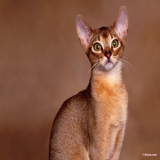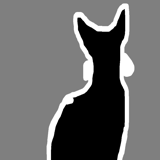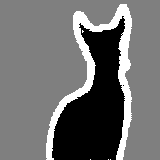

##몇가지 모델을 더 test해 보려면 

https://github.com/divamgupta/image-segmentation-keras   
https://colab.research.google.com/drive/1q_eCYEzKxixpCKH1YDsLnsvgxl92ORcv?usp=sharing  

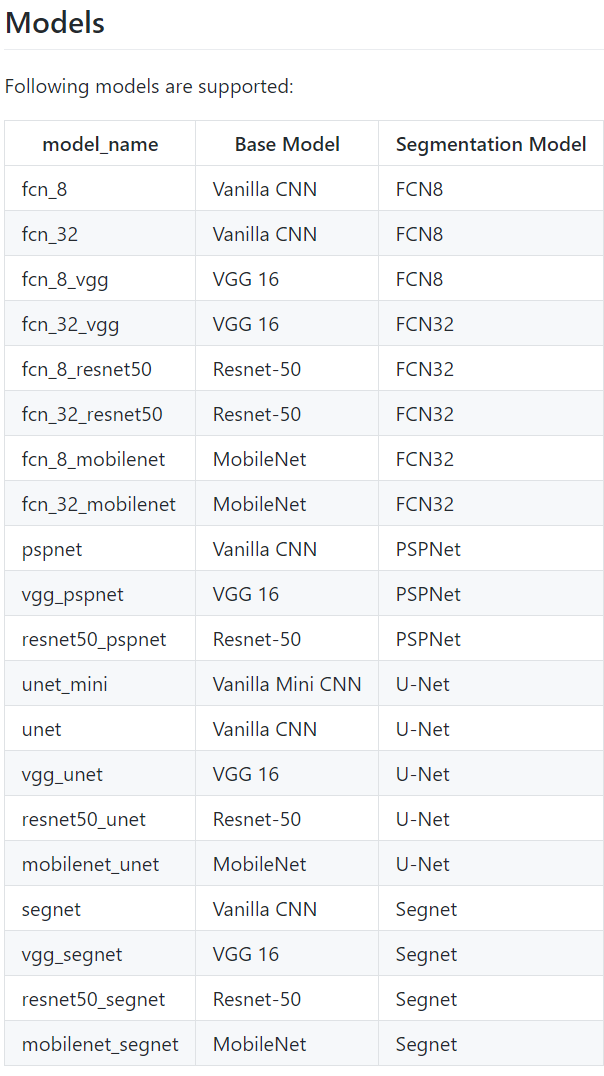